In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #visualisation
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
from zipfile import ZipFile

DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
with ZipFile('../data/train.csv.zip', 'r') as zip:
    zip.extractall('../data')

In [3]:
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [4]:
from helpers_perso import standardize
#Let's see the dimension of the input and output
#tx, mean_x, std_x = standardize(tX)
#tX.shape, mean_x, std_x, y.shape

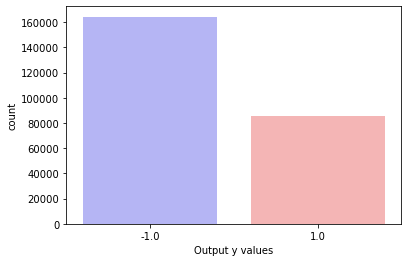

In [5]:
#Exploring y
sns.countplot(x = y, palette = "bwr") 
plt.xlabel("Output y values")
plt.show()

We can remark that the data are not well balanced for the output and this can cause some trouble.

30


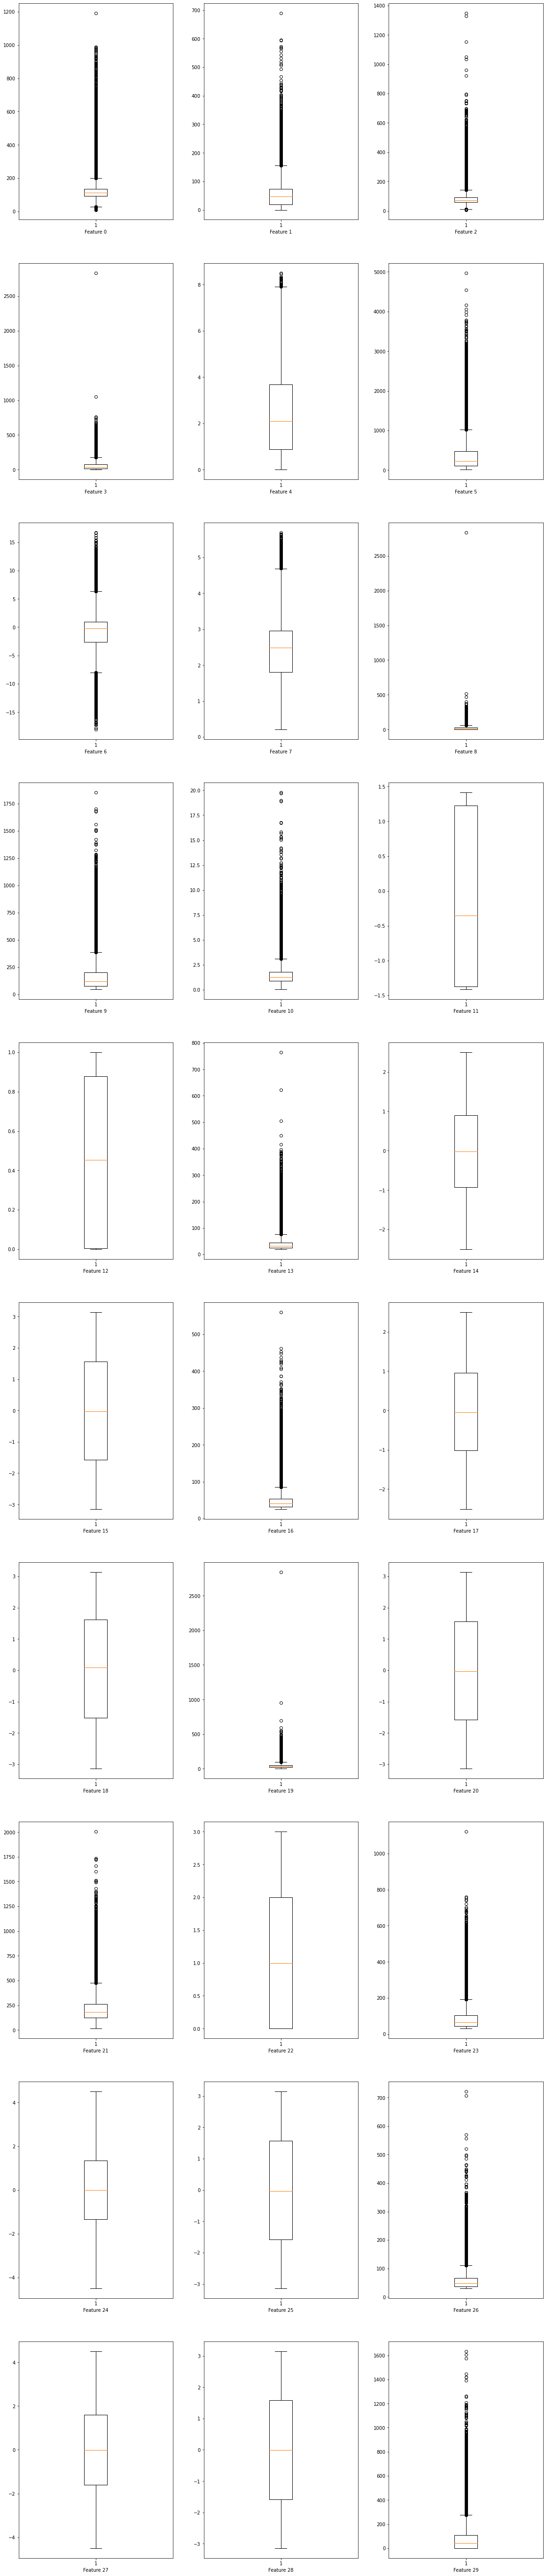

In [6]:
fig = plt.figure()
print(tX.shape[1])
number_features = tX.shape[1]
for i in range(0, number_features):
    ax = fig.add_subplot(10, 3, i+1)
    #remove useless values
    tX_tmp = tX[:, i]
    tX_tmp = tX_tmp[tX_tmp > -999]
    plt.boxplot(tX_tmp)
    plt.xlabel("Feature " + str(i))
fig.set_size_inches(20, 100)

30


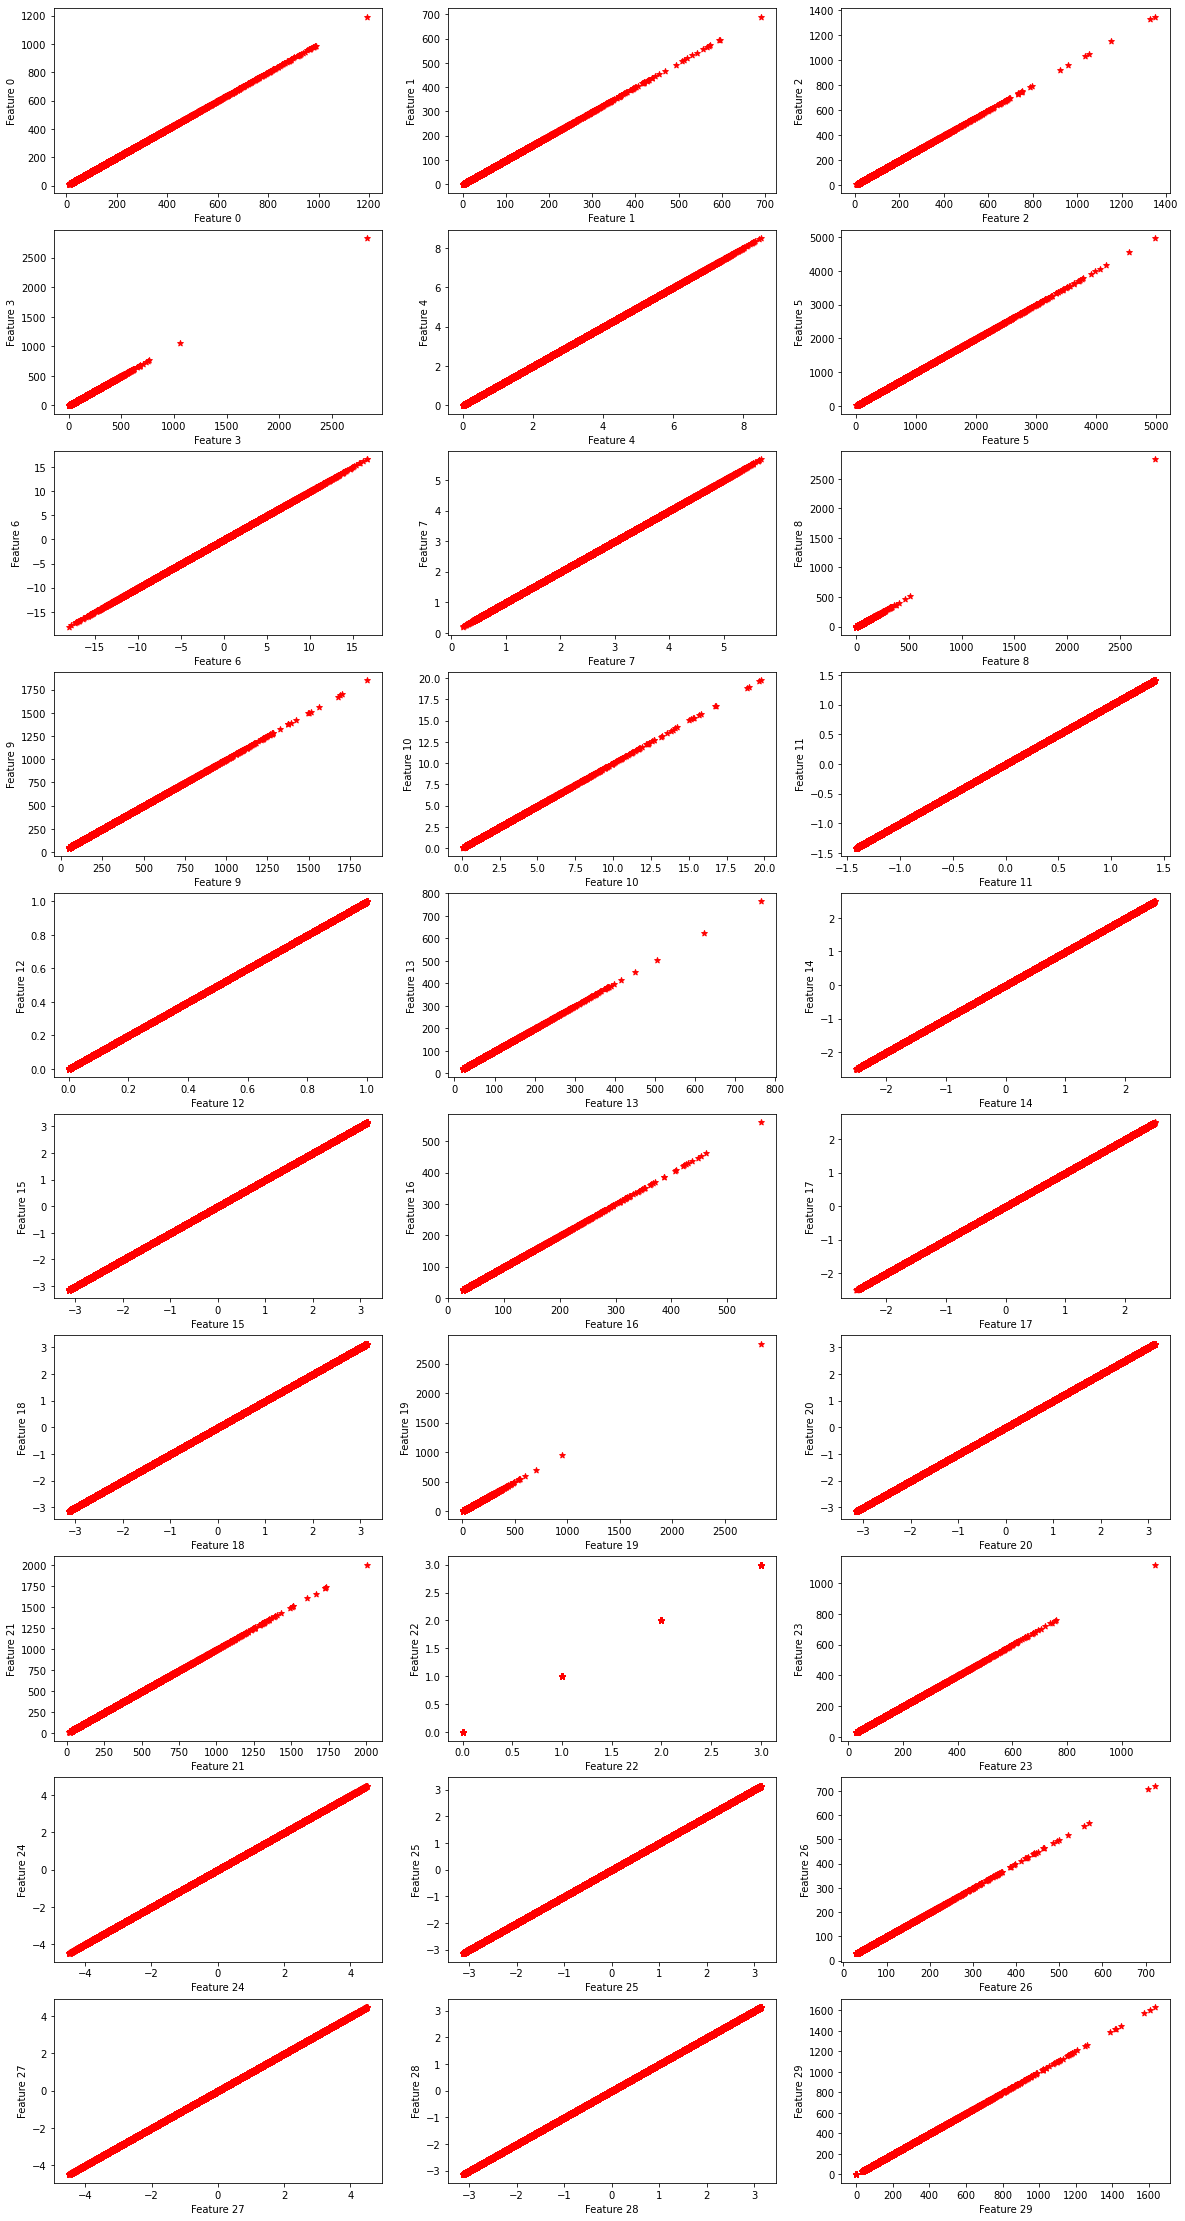

In [7]:
fig = plt.figure()
print(tX.shape[1])
number_features = tX.shape[1]
for i in range(0, number_features):
    ax = fig.add_subplot(10, 3, i+1)
    #remove useless values
    tX_tmp = tX[:, i]
    tX_tmp = tX_tmp[tX_tmp > -999]
    ax.scatter(tX_tmp, tX_tmp, marker= "*", color= "r")
    ax.set_xlabel("Feature " + str(i))
    ax.set_ylabel("Feature " + str(i))
fig.set_size_inches(20, 40)

### Interpretation

Thoses graphs shows the distribution of the features. 
We can see directly that a feature is categorical :
- Feature with 4 categories : 22

For the other features, we can see that only a few of them seems well distributed whereas the other have some outliers :
- Features with Outliers : 0, 1, 2, 3, 5, 8, 9, 10, 13, 16, 19, 21, 26, 29



# Feature processing 

Feature processing : Cleaning the dataset by removing useless features and values, combining others, finding better representations of the features to feed your model, scaling the features, and so on. Check this article
on feature engineering: 

http://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/

## Removing useless features

In [8]:
tX
tX.shape

(250000, 30)

In [9]:
# Removing useless features

# We begin by removing all the line with a PRI_jet_all_pt equal to 0
#print(tX.shape, y.shape, ids.shape)
#line_array = np.int_([])
#for i in range (tX.shape[0]):
#    if tX[i, 29] == 0. :
#        line_array = np.append(line_array, i)
#tX = np.delete(tX, line_array, axis=0)
#y = np.delete(y, line_array, axis=0)
#ids = np.delete(ids, line_array, axis=0) 
#tX = tX[np.where(tX[:, 29] != 0.)]
#print(tX[:15,:])
#tX.shape, y.shape, ids.shape

In [10]:
#Useless feature with

In [11]:
# Removing rows with missing values (Nan)

#tX = tX[~np.isnan(tX).any(axis=1)]
#print(tX[:15,:])
#tX.shape

In [12]:
#Correlation between features
linear_relation = []
mat = np.corrcoef(tX, rowvar = 0)
#print(mat)
for i in range(mat.shape[0]):
    for j in range(0, i):
        if mat[i, j] > 0.999:
            linear_relation.append((j, i, mat[i, j]))
linear_relation

[(4, 6, 0.999981427683375),
 (4, 12, 0.9999983857136833),
 (6, 12, 0.9999896746909288),
 (24, 25, 0.9999918368931442),
 (4, 26, 0.9993463699208786),
 (6, 26, 0.999346573841989),
 (12, 26, 0.9993546311799896),
 (4, 27, 0.9999949302305665),
 (6, 27, 0.9999879777937469),
 (12, 27, 0.9999969759820075),
 (26, 27, 0.9993523477702628),
 (4, 28, 0.999995543387923),
 (6, 28, 0.9999886069465234),
 (12, 28, 0.9999975565729753),
 (26, 28, 0.9993518514848312),
 (27, 28, 0.9999947740006576)]

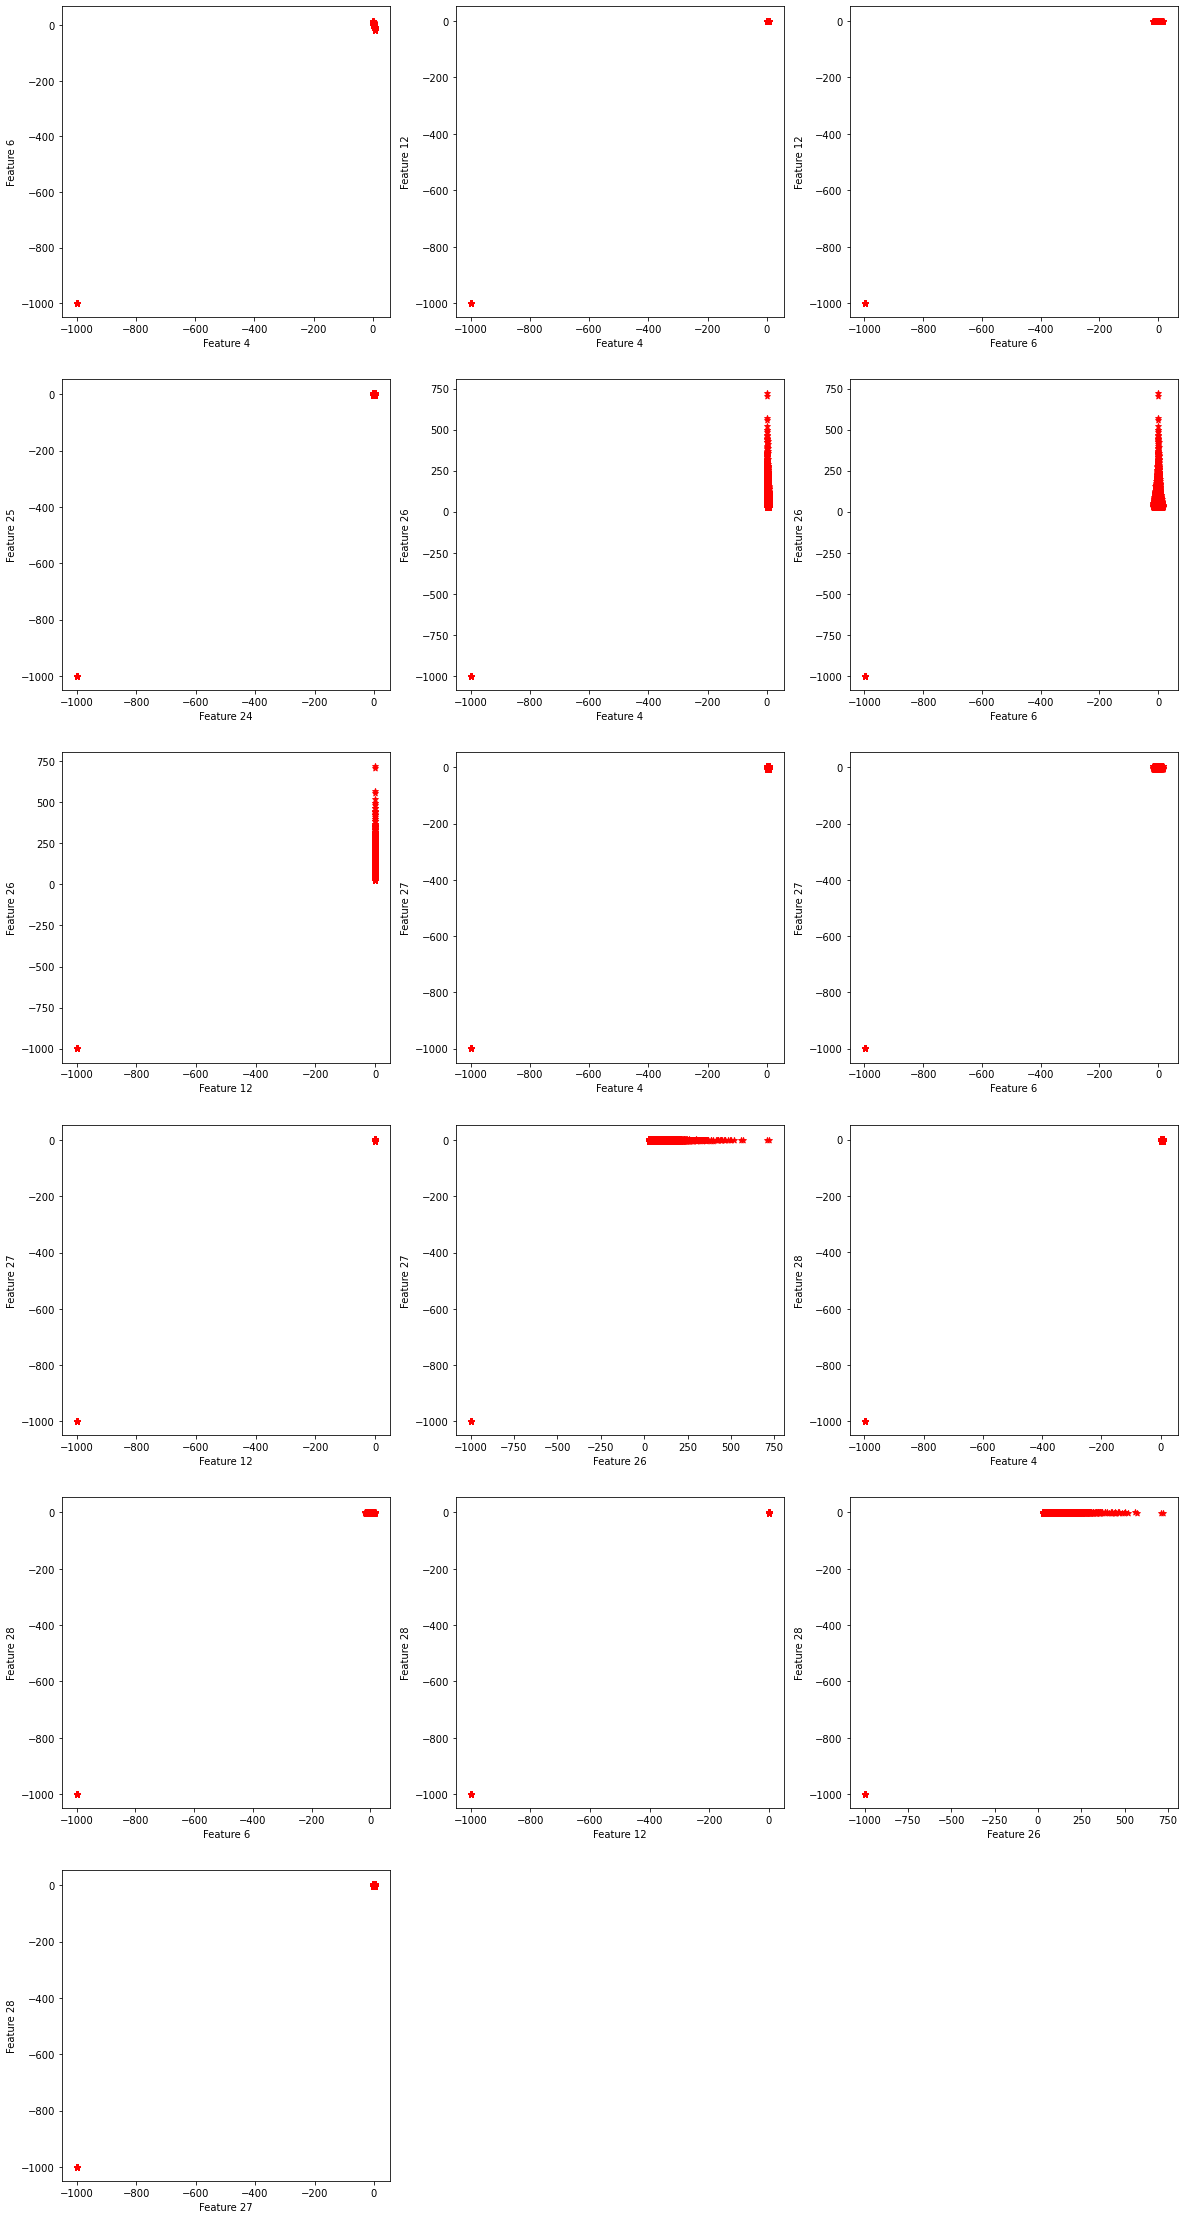

In [13]:
from math import *
#Visualization for the linear relation between feature
fig = plt.figure()
k = 1
for (i, j, r) in linear_relation : 
    ax = fig.add_subplot((len(linear_relation)//3)+1, 3, k)
    #we keep useless values to see the relation between features when one is -999
    ax.scatter(tX[:,i], tX[:,j], marker= "*", color= "r")
    ax.set_xlabel("Feature " + str(i))
    ax.set_ylabel("Feature " + str(j))
    k += 1
fig.set_size_inches(20, 40)

In [14]:
#As they are corrolated, we can remove one of the features in the final input 
column_array = np.int_([])
for (i, j, r) in linear_relation :
    if not (i in column_array) :
        column_array = np.append(column_array, i)
    else :
        if not (j in column_array) :
            column_array = np.append(column_array, j)
tX = np.delete(tX, column_array, axis=1)
tX.shape

(250000, 23)

We will now work only with 22 features

### Corrolation with prediction :

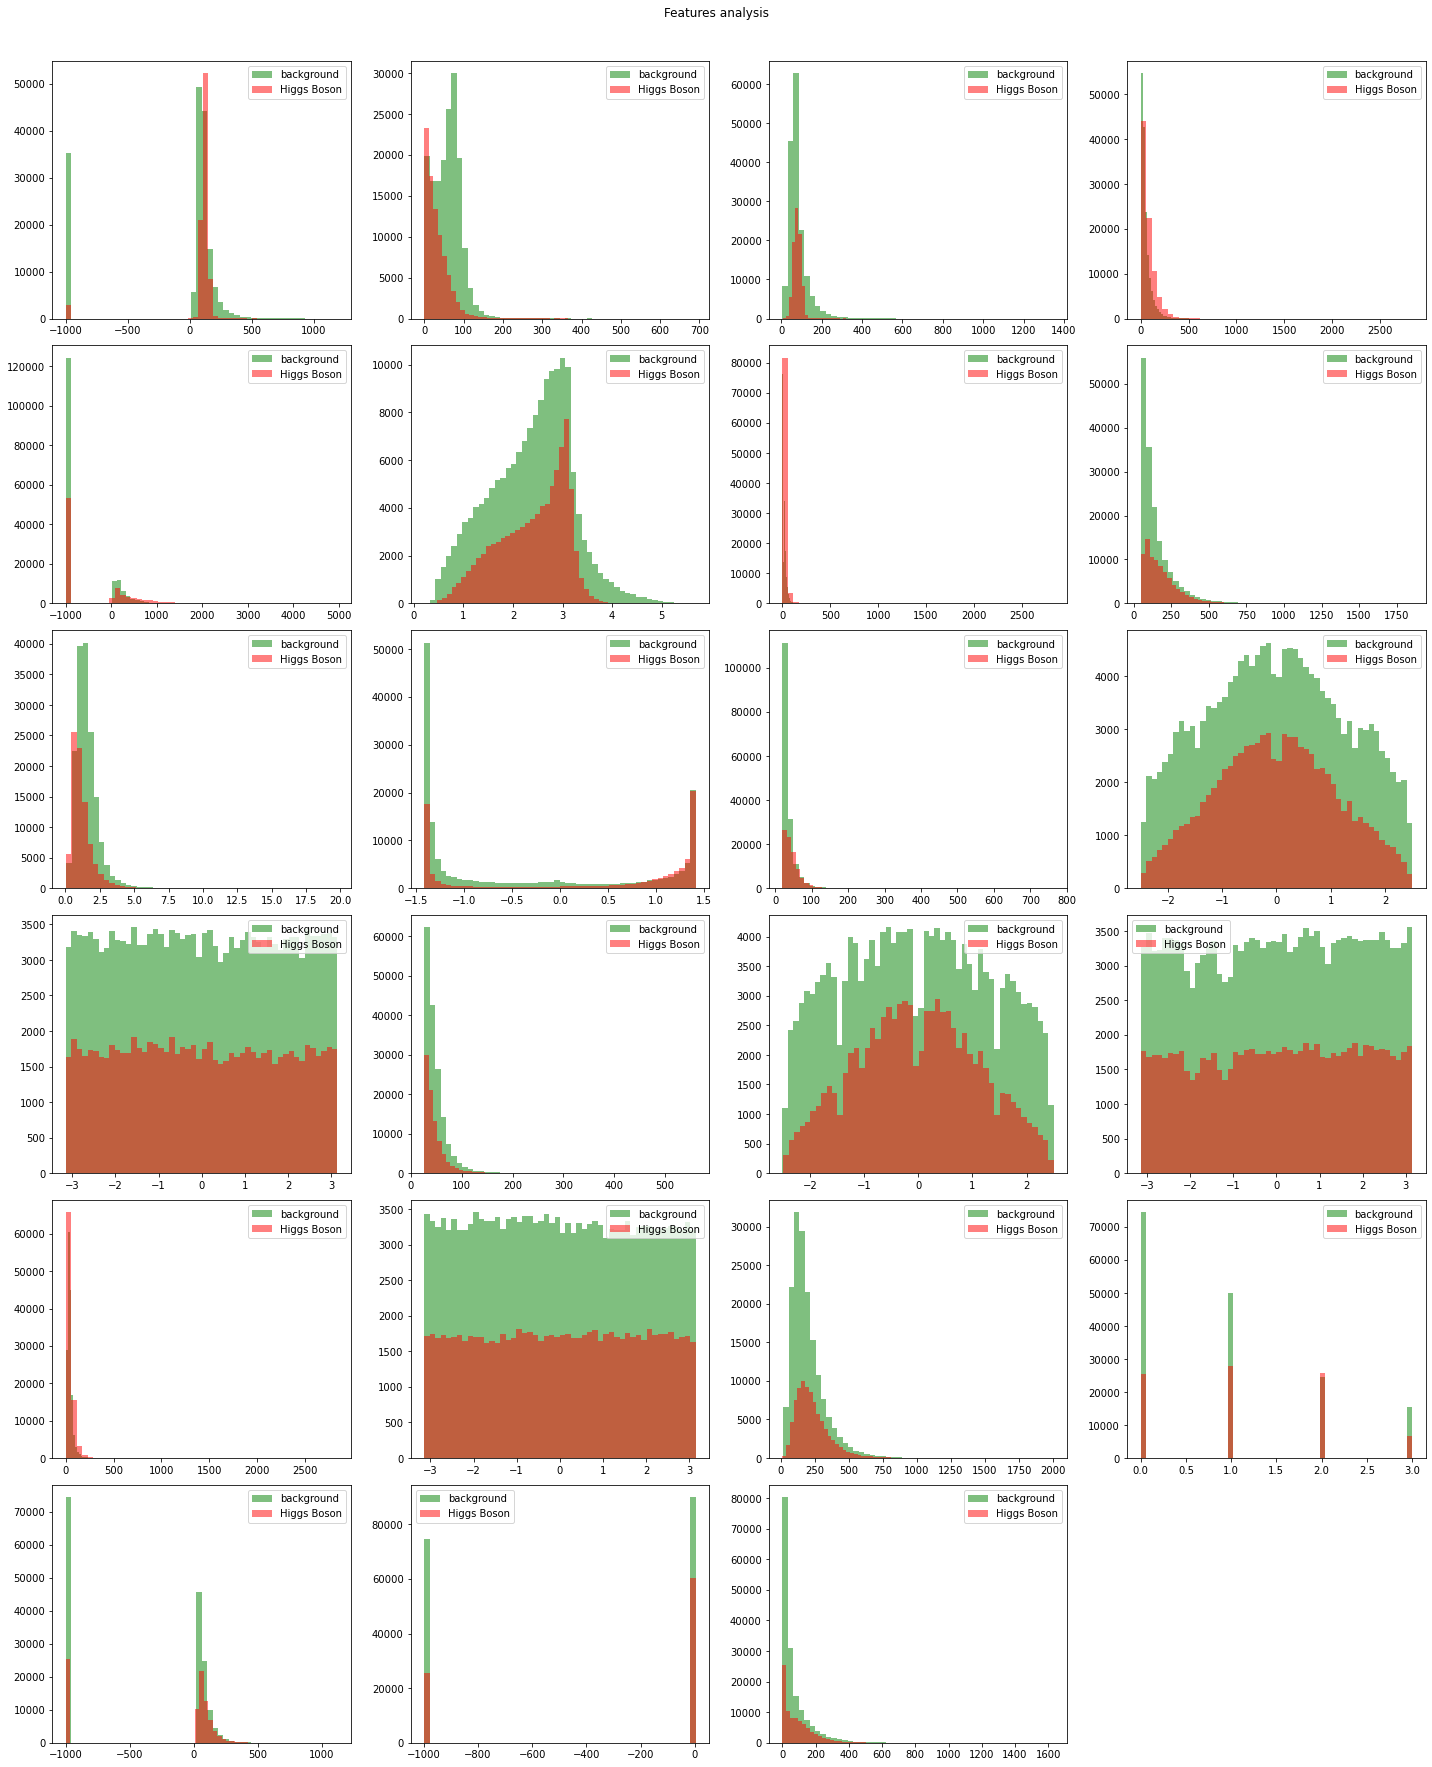

In [29]:
fig = plt.figure(figsize = (20, 25))
j = 0

#Constructing a new matrice for esier plot
y_reshaped = y.reshape(y.shape[0], 1)
mat = np.concatenate((y_reshaped, tX), axis=1)

#print (mat)
#print(mat_one)
    
#print(np.where(mat[:, 0] == -1.))
#print(mat[np.where(mat[:, 0] == -1.), 2])
for i in range(1, mat.shape[1]):
    plt.subplot(6, 4, j+1)
    j += 1
    plt.hist(mat[np.where(mat[:, 0] == -1.), i].flatten(), bins= 50, color='g', label = 'background', alpha=0.5)
    plt.hist(mat[np.where(mat[:, 0] == 1.), i].flatten(), bins=50, color='r', label = 'Higgs Boson', alpha=0.5)
    ply
    plt.legend(loc='best')
fig.suptitle('Features analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [ ]:
#Corrolation of features with the prediction
tX_y_relation = []
mat = np.corrcoef(tX, y, rowvar = 0)
print(mat)
for i in range(mat.shape[0]):
    for j in range(0, i):
        if mat[i, j] > 0.999:
            tX_y_relation.append((j, i, mat[i, j]))
#linear_relation
for (i, j, r) in linear_relation : 
    ax = fig.add_subplot((len(linear_relation)//3)+1, 3, k)
    #we keep useless values to see the relation between features when one is -999
    ax.scatter(tX[:,i], tX[:,j], marker= "*", color= "r")
    ax.set_xlabel("Feature " + str(i))
    ax.set_ylabel("Feature " + str(j))
    k += 1
fig.set_size_inches(20, 40)

## Do your thing crazy machine learning thing here :) ...

## Generate predictions and save ouput in csv format for submission:

In [ ]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
with ZipFile('../data/test.csv.zip', 'r') as zip:
    zip.extractall('../data')
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
OUTPUT_PATH = '../data/output.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)